---

## Reinforcement Learning Final Project

**File:** `main.ipynb`  
**Author:** Hamid Manouchehri & Christ Joe Maria Anantharaj  
**Email:** hmanouch@buffalo.edu & christjo@buffalo.edu  
**Date:** Apr 10, 2025


---

### Description:
Robotic manipulator on pybullet simulator for gripping an inhomogeneous object 
from its COM to avoid tilting while lifting the object. 

---

### License:
This script is licensed under the **MIT License**.  
You may obtain a copy of the License at:  
🔗 [https://opensource.org/licenses/MIT](https://opensource.org/licenses/MIT)

**SPDX-License-Identifier:** MIT

---

### Disclaimer:
> This software is provided "as is", without warranty of any kind, express or implied, including but not limited to the warranties of merchantability, fitness for a particular purpose, and noninfringement.  
> In no event shall the authors be liable for any claim, damages, or other liability, whether in an action of contract, tort, or otherwise, arising from, out of, or in connection with the software or the use or other dealings in the software.

---

In [10]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pybullet as p
import pybullet_data
import matplotlib.pyplot as plt
from types import SimpleNamespace
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

## Defining the PyBullet GUI with the Robot arm and the Object

In [11]:
# Connect to PyBullet and set up the environment

# p.connect(p.GUI)
p.connect(p.DIRECT)
p.resetSimulation()
p.setAdditionalSearchPath(pybullet_data.getDataPath())
# p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)  # Optionally hide the PyBullet GUI

# Load the KUKA robot and environment objects
planeId = p.loadURDF("plane.urdf")
cuboid_green_id = p.loadURDF("./object/block.urdf", [0.54, 0, 0.02], [0, 0, 0, 1])
kuka_id = p.loadURDF("kuka_iiwa/kuka_with_prismatic_gripper.urdf")

p.setGravity(0, 0, -10)
p.resetDebugVisualizerCamera(
    cameraDistance=2.0,    # Zoom level (2 meters away)
    cameraYaw=75,          # Rotation around the vertical axis
    cameraPitch=-40,       # Tilt downward
    cameraTargetPosition=[0, 0, 0]  # Focus on the origin
)

numJoints = p.getNumJoints(kuka_id)  # Total joints: KUKA + gripper

# Initialize the joints dictionary
joints = {}

# Populate the joints dictionary with information about each joint
for joint_index in range(numJoints):
    joint_info = p.getJointInfo(kuka_id, joint_index)
    joint_name = joint_info[1].decode("utf-8")
    joints[joint_name] = SimpleNamespace(
        id=joint_info[0],
        lowerLimit=joint_info[8],
        upperLimit=joint_info[9],
        maxForce=joint_info[10],
        maxVelocity=joint_info[11],
    )

## Defining the Environment

In [12]:
class BulletKukaEnvironment(gym.Env):
    def __init__(self, gui=True):
        self.sim_time_step = 1 / 60
        self.eff_index = 7
        self.home_kuka_joint_angle = np.array([0.0] * 7)
        self.init_kuka_joint_angle = np.array([-0., 0.44, 0., -2.086, -0., 0.615, -0.])
        self.previous_eef_pos = None
        self.tilt_threshold = 0.5

        self.action_space = spaces.Discrete(2)  # 0: xPlus, 1: xMinus
        self.observation_space = spaces.Box(low=np.array([0.0, -np.pi]), high=np.array([1.0, np.pi]), dtype=np.float32)

        self.step_count = 0
        self.max_steps = 20

    def reset(self):
        self.set_kuka_joint_angles(self.home_kuka_joint_angle, self.init_kuka_joint_angle, duration=1)
        self.operate_gripper(init_pos=0., fin_pos=0.01, duration=1)  #  Open gripper
        p.resetBasePositionAndOrientation(cuboid_green_id, [0.54, 0, 0.02], [0, 0, 0, 1])

        eef_pos, _ = self.get_current_eef_pose()
        self.previous_eef_pos = eef_pos
        
        self.step_count = 0
        self.grasp_attempts = 0
        
        eef_pos, _ = self.get_current_eef_pose()
        obj_tilt = self.get_object_state(cuboid_green_id)[1]
        obs = np.array([eef_pos[0], obj_tilt], dtype=np.float32)
        return obs

    def calculate_ik(self, position, orientation):
        quaternion = p.getQuaternionFromEuler(orientation)
        lower_limits = [-np.pi] * 7
        upper_limits = [np.pi] * 7
        joint_ranges = [2 * np.pi] * 7
        rest_poses = [(-0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0)]  # Rest pose for 7 DOF
        # Calculate inverse kinematics with a 7-element damping vector
        joint_angles = p.calculateInverseKinematics(
            kuka_id, self.eff_index, position, quaternion,
            jointDamping=[0.01] * 7,
            lowerLimits=lower_limits,
            upperLimits=upper_limits,
            jointRanges=joint_ranges,
            restPoses=rest_poses
        )
        return joint_angles

    def set_kuka_joint_angles(self, init_joint_angles, des_joint_angles, duration):
        control_joints = ["lbr_iiwa_joint_1", "lbr_iiwa_joint_2", "lbr_iiwa_joint_3",
                        "lbr_iiwa_joint_4", "lbr_iiwa_joint_5", "lbr_iiwa_joint_6",
                        "lbr_iiwa_joint_7"]
        poses = []
        indexes = []
        forces = []
        for i, name in enumerate(control_joints):
            joint = joints[name]
            poses.append(des_joint_angles[i])
            indexes.append(joint.id)
            forces.append(joint.maxForce)
        trajectory = self.interpolate_trajectory(init_joint_angles, des_joint_angles, duration)
        for q_t in trajectory:
            p.setJointMotorControlArray(
                kuka_id, indexes,
                controlMode=p.POSITION_CONTROL,
                targetPositions=q_t,
                forces=forces
            )
            p.stepSimulation()
            # time.sleep(self.sim_time_step)

    def position_path(self, t, t_max, start_pos, end_pos):
        return start_pos + (end_pos - start_pos) * (t / t_max)

    def orientation_path(self, t, t_max, start_orient, end_orient):
        """Orientation path (Euler angles)."""
        return start_orient + (end_orient - start_orient) * (t / t_max)

    def get_current_eef_pose(self):
        linkstate = p.getLinkState(kuka_id, self.eff_index, computeForwardKinematics=True)
        position, orientation = linkstate[0], linkstate[1]
        position = list(position)
        position[2] = position[2] - 0.0491
        return (position, list(p.getEulerFromQuaternion(orientation)))

    def get_current_joint_angles(self, kuka_or_gripper=None):
        joint_states = p.getJointStates(kuka_id, list(range(numJoints)))
        joint_values = [state[0] for state in joint_states]
        if kuka_or_gripper == 'kuka':
            return joint_values[:7]  # First 7 joints for the KUKA arm
        elif kuka_or_gripper == 'gripper':
            return joint_values[7:]  # Remaining joints for the gripper
        else:
            return joint_values

    def interpolate_trajectory(self, q_start, q_end, duration):
        num_steps = int(duration / self.sim_time_step) + 1
        trajectory = []
        for t in range(num_steps):
            alpha = t / (num_steps - 1)
            q_t = [q_start[i] + alpha * (q_end[i] - q_start[i]) for i in range(len(q_start))]
            trajectory.append(q_t)
        return trajectory

    def moveL(self, start_pos, end_pos, target_ori, duration):
        """
        Moves the robot's end-effector in a straight line from start_pos to end_pos.
        """
        num_steps = int(duration / self.sim_time_step) + 1
        target_quat = p.getQuaternionFromEuler(target_ori)
        for step in range(num_steps):
            alpha = step / (num_steps - 1)
            current_pos = np.array(start_pos) + alpha * (np.array(end_pos) - np.array(start_pos))
            
            if current_pos[2] < 0.05:  
                current_pos[2] = 0.05
            
            joint_poses = p.calculateInverseKinematics(kuka_id, self.eff_index, current_pos.tolist(), target_quat)
            control_joint_indices = list(range(7))
            target_positions = joint_poses[:7]
            p.setJointMotorControlArray(kuka_id, control_joint_indices,
                                        controlMode=p.POSITION_CONTROL,
                                        targetPositions=target_positions)
            p.stepSimulation()
            # time.sleep(self.sim_time_step)

    def execute_task_space_trajectory(self, start_pos, final_pos, duration=1):
        all_joint_angles = self.calculate_ik(final_pos[0], final_pos[1])
        des_kuka_joint_angles = all_joint_angles[:7]
        self.set_kuka_joint_angles(self.get_current_joint_angles("kuka"), des_kuka_joint_angles, duration)

    def operate_gripper(self, init_pos, fin_pos, duration=1):
        """
        Smoothly open or close the gripper by interpolating the gripper opening angle.
        """
        control_joints = ["left_finger_sliding_joint", "right_finger_sliding_joint"]
        poses = []
        indexes = []
        forces = []
        
        init_arr = np.array([-init_pos, init_pos])
        fin_arr = np.array([-fin_pos, fin_pos])
        for i, name in enumerate(control_joints):
            joint = joints[name]
            poses.append(fin_arr[i])
            indexes.append(joint.id)
            forces.append(joint.maxForce)
        trajectory = self.interpolate_trajectory(init_arr, fin_arr, duration)
        for q_t in trajectory:
            p.setJointMotorControlArray(
                kuka_id, indexes,
                controlMode=p.POSITION_CONTROL,
                targetPositions=q_t,
                forces=forces
            )
            p.stepSimulation()
            # time.sleep(self.sim_time_step)

    def get_object_state(self, object_id):
        position, orientation = p.getBasePositionAndOrientation(object_id)
        orientation_euler = p.getEulerFromQuaternion(orientation)
        return orientation_euler
    

    def execute_grip_action(self):
        """ 
        Move the gripper down, grip the object, lift it up and put it down again, 
        finally bring the gripper up to its initial position.
        """

        current_eef_pos, current_eef_orien = self.get_current_eef_pose()
        next_eef_pos = current_eef_pos.copy()
        # next_eef_pos[2] = next_eef_pos[2] - 0.1225

        obj_pos, _ = p.getBasePositionAndOrientation(cuboid_green_id)
        next_eef_pos[2] = obj_pos[2] + 0.02

        self.moveL(current_eef_pos, next_eef_pos, current_eef_orien, duration=1)
        self.operate_gripper(init_pos=0.01, fin_pos=0.00001, duration=0.5)  # Close gripper
        self.moveL(next_eef_pos, current_eef_pos, current_eef_orien, duration=1)
        obj_tilt_angle = self.get_object_state(cuboid_green_id)[1]
        self.moveL(current_eef_pos, next_eef_pos, current_eef_orien, duration=1)
        self.operate_gripper(init_pos=0., fin_pos=0.01, duration=1)  # Open gripper
        self.moveL(next_eef_pos, current_eef_pos, current_eef_orien, duration=1)

        return obj_tilt_angle
    

    def step(self, action):
        self.step_count += 1

        x_step = 0.05
        current_eef_pos, current_eef_orien = self.get_current_eef_pose()

        if hasattr(self, 'previous_eef_pos'):
            previous_eef_pos = self.previous_eef_pos
        else:
            previous_eef_pos = current_eef_pos
        
        next_eef_pos = current_eef_pos.copy()

        if action == 0:  # xPlus
            next_eef_pos[0] += x_step
        elif action == 1:  # xMinus
            next_eef_pos[0] -= x_step

        self.moveL(current_eef_pos, next_eef_pos, current_eef_orien, duration=2)

        # Check if the robot has actually moved
        post_move_pos, _ = self.get_current_eef_pose()
        movement_distance = np.linalg.norm(np.array(post_move_pos) - np.array(current_eef_pos))
        self.previous_eef_pos = post_move_pos  
        
        # Cheking if the robot is stuck
        if movement_distance < 0.05:  
            obs = np.array([post_move_pos[0], 0], dtype=np.float32)
            return obs, -3.0, False, {"stuck": True}

        # Find object tilt angle
        tilt = self.execute_grip_action()

        obj_pos, _ = p.getBasePositionAndOrientation(cuboid_green_id)
        
        # Create observation
        obs = np.array([next_eef_pos[0], tilt], dtype=np.float32)

        # Calculate rewards
        tilt_penalty = abs(tilt) * 5
        height_reward = max(0, obj_pos[2] - 0.05) * 10  
        position_reward = -abs(next_eef_pos[0] - 0.5) * 2

        # Calculate total reward
        reward = height_reward - tilt_penalty + position_reward 

        # Success if object is lifted with minimal tilt
        success = (abs(tilt) <= self.tilt_threshold)
        if success:
            reward += 10 
        else:
            reward -= 2
    
        terminated = (self.step_count >= self.max_steps)
        
        if success:
            terminated = True
        

        info = {
            "tilt_angle": tilt,
            "obj_height": obj_pos[2],
            "success": success
        }

        return obs, reward, terminated, info

## DQN Implementation

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DQN:
    def __init__(self, env, gamma=0.99, batch_size=16):
        self.env = env
        self.state_dim = 2  
        self.action_dim = 2  
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.C = 10  
        self.learning_rate = 1e-3 
        
        self.Q_policy = NeuralNetwork(self.state_dim, self.action_dim)
        self.Q_prime = NeuralNetwork(self.state_dim, self.action_dim)
        self.Q_prime.load_state_dict(self.Q_policy.state_dict())
        self.Q_prime.eval()
        
        self.optimizer = torch.optim.Adam(self.Q_policy.parameters(), lr=self.learning_rate)
        self.replay_buffer = deque([], maxlen=1000)
        self.criterion = nn.MSELoss()
        
        self.total_steps = 0
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = np.exp(np.log(self.epsilon_min / 1.0) / 100)
        self.total_rewards = []
        self.epsilon_values = []

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            with torch.no_grad():
                q_values = self.Q_policy(state)
                return q_values.max(1)[1].item()

    def update_model(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = random.sample(self.replay_buffer, self.batch_size)
        
        states = torch.tensor([s[0] for s in batch], dtype=torch.float32)
        actions = torch.tensor([s[1] for s in batch], dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor([s[2] for s in batch], dtype=torch.float32)
        next_states = torch.tensor([s[3] for s in batch], dtype=torch.float32)
        dones = torch.tensor([s[4] for s in batch], dtype=torch.float32)

        q_values = self.Q_policy(states).gather(1, actions)

        next_q_values = self.Q_prime(next_states).max(1)[0].unsqueeze(1)

        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        td_errors = torch.abs(q_values - expected_q_values).detach().cpu().numpy()
        loss = self.criterion(q_values, expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.Q_policy.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

    def train(self, num_episodes=500):
        for episode in range(num_episodes):
            state = self.env.reset()
            episode_reward = 0

            for step in range(self.env.max_steps):
                action = self.select_action(state)
                next_state, reward, done, info = self.env.step(action)
                episode_reward += reward

                self.replay_buffer.append((state, action, reward, next_state, done))

                if len(self.replay_buffer) >= self.batch_size:
                    self.update_model()

                if self.total_steps % self.C == 0:
                    self.Q_prime.load_state_dict(self.Q_policy.state_dict())

                state = next_state
                self.total_steps += 1

                if done:
                    break

            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            self.epsilon_values.append(self.epsilon)
            self.total_rewards.append(episode_reward)

            print(f"Episode {episode+1}/{num_episodes} | Reward: {episode_reward:.2f}")

        print("Training complete!")
        return self.total_rewards

    

## Training the DQN Agent

In [14]:
env = BulletKukaEnvironment()
dqn_agent = DQN(env)
rewards = dqn_agent.train(num_episodes=100)
dqn_rewards = rewards

c:\Users\Christ Joe\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\Christ Joe\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Episode 1/100 | Reward: -26.44


c:\Users\Christ Joe\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([16, 16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 2/100 | Reward: -37.09
Episode 3/100 | Reward: 3.46
Episode 4/100 | Reward: -2.10
Episode 5/100 | Reward: -2.30
Episode 6/100 | Reward: -7.34
Episode 7/100 | Reward: -31.08
Episode 8/100 | Reward: -1.34
Episode 9/100 | Reward: -5.08
Episode 10/100 | Reward: -20.61
Episode 11/100 | Reward: -60.00
Episode 12/100 | Reward: 3.46
Episode 13/100 | Reward: -60.00
Episode 14/100 | Reward: -26.29
Episode 15/100 | Reward: -2.54
Episode 16/100 | Reward: 3.46
Episode 17/100 | Reward: 3.46
Episode 18/100 | Reward: 3.46
Episode 19/100 | Reward: 3.46
Episode 20/100 | Reward: -2.54
Episode 21/100 | Reward: -2.56
Episode 22/100 | Reward: 3.46
Episode 23/100 | Reward: 3.46
Episode 24/100 | Reward: -2.54
Episode 25/100 | Reward: -14.21
Episode 26/100 | Reward: -15.12
Episode 27/100 | Reward: 3.46
Episode 28/100 | Reward: -42.91
Episode 29/100 | Reward: 3.46
Episode 30/100 | Reward: 3.46
Episode 31/100 | Reward: -2.54
Episode 32/100 | Reward: 3.46
Episode 33/100 | Reward: 3.46
Episode 34/100 | Rew

## Rewards per Episode plot

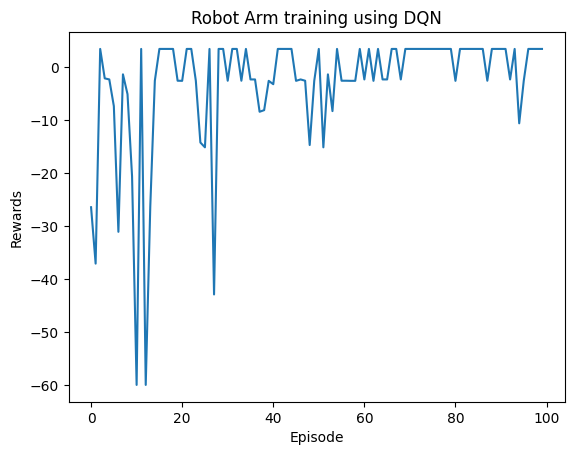

In [15]:
plt.plot(dqn_rewards)
plt.title("Robot Arm training using DQN")
plt.xlabel("Episode")
plt.ylabel("Rewards")
plt.show()

## Epsilon-Decay plot

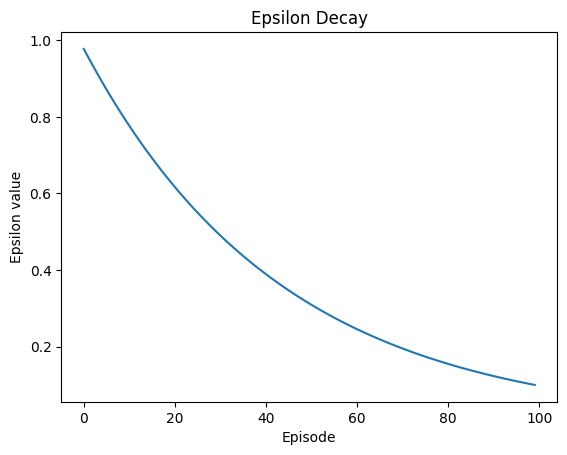

In [16]:
plt.plot(dqn_agent.epsilon_values)
plt.title("Epsilon Decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon value")
plt.show()

## Saving the model

In [17]:
torch.save(dqn_agent.Q_policy.state_dict(), 'robot_arm_dqn.pth')

In [18]:
np.mean(dqn_rewards)

-3.093027767901323